### Estratégia de Imputação KNN com Ponderação por Eta²

####  Objetivo
Imputar valores ausentes na variável categórica `Type_of_glass`, utilizando as variáveis numéricas como base, com um **KNN personalizado** que utiliza pesos derivados da **associação estatística (Eta²)**.

---

#### Etapas da Abordagem

##### 1. Simulação de valores ausentes:
- Gerar valores ausentes de forma **MCAR** (*Missing Completely At Random*) na coluna `Type_of_glass`.

##### 2. Cálculo do Eta² (*Eta Squared*):
- Para cada variável numérica, calcular o **eta quadrado** em relação a `Type_of_glass`.
- O **eta² quantifica a associação** entre a variável numérica e a categórica.
- Valores mais altos indicam **maior poder preditivo**.

##### 3. Pré-processamento dos dados:
- **Normalizar** todas as variáveis numéricas (ex: Min-Max ou Z-score);
- **Multiplicar** cada variável normalizada pelo seu **eta²**, criando uma **representação ponderada dos dados**.

##### 4. Imputação via KNN personalizado:
Para cada linha com `Type_of_glass` ausente:
- Calcular a **distância** (ex: Euclidiana ou Gower ponderada) entre essa linha e as outras com `Type_of_glass` conhecido;
- Selecionar os **k vizinhos mais próximos**;
- Imputar com a **moda** dos `Type_of_glass` entre esses vizinhos.

---

#### Vantagens da Abordagem
- Leva em conta **quais variáveis são mais relevantes** para prever `Type_of_glass`;
- Melhora a qualidade da imputação comparado a **KNN simples** ou **imputação por moda global**;
- É especialmente útil quando só há **uma variável categórica e muitas numéricas**.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from collections import Counter
import random

# 1. Carregar e preparar os dados
file_path = 'data/glass.data'
columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type_of_glass']

df = pd.read_csv(file_path, header=None, names=columns)
df.drop(columns=['Id'], inplace=True)

# Salvar os dados originais para avaliação
df_original = df.copy()

random.seed(42)

# 2. Inserir valores ausentes (MCAR) em Type_of_glass
missing_frac = 0.2
n_missing = int(missing_frac * len(df))
missing_indices = random.sample(list(df.index), n_missing)
df.loc[missing_indices, 'Type_of_glass'] = np.nan

# 3. Calcular o Eta² para cada variável numérica em relação a Type_of_glass
def eta_squared(x, y):
    classes = y.dropna().unique()
    grand_mean = x[y.notna()].mean()
    ss_between = sum([
        len(x[y == cl]) * ((x[y == cl].mean() - grand_mean) ** 2)
        for cl in classes
    ])
    ss_total = sum((x[y.notna()] - grand_mean) ** 2)
    return ss_between / ss_total if ss_total != 0 else 0

numerical_cols = df.columns.drop('Type_of_glass')
etas = {col: eta_squared(df[col], df['Type_of_glass']) for col in numerical_cols}
etas_series = pd.Series(etas)

# 4. Normalizar e aplicar pesos Eta²
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)
df_weighted = df_scaled * etas_series

# 5. Função de imputação com KNN usando distância euclidiana
def knn_impute(row_idx, df_weighted, df_target, k=5):
    row = df_weighted.iloc[row_idx].values.reshape(1, -1)

    # Seleciona apenas amostras conhecidas
    df_known = df_weighted[df_target.notna()]
    target_known = df_target[df_target.notna()]

    if df_known.empty:
        return target_known.mode().iloc[0]

    distances = cdist(row, df_known.values, metric='euclidean').flatten()
    nearest_indices = df_known.index[np.argsort(distances)[:k]]
    nearest_labels = target_known.loc[nearest_indices].dropna()

    if nearest_labels.empty:
        return target_known.mode().iloc[0]

    return Counter(nearest_labels).most_common(1)[0][0]

# 6. Aplicar imputação
df_imputed = df['Type_of_glass'].copy()
missing_mask = df_imputed.isna()

for idx in df[missing_mask].index:
    df_imputed[idx] = knn_impute(idx, df_weighted, df['Type_of_glass'])

# 7. Avaliação da Imputação
true_values = df_original.loc[missing_indices, 'Type_of_glass']
predicted_values = df_imputed.loc[missing_indices]
acuracia = accuracy_score(true_values, predicted_values)

print(f"Taxa de acerto da imputação: {acuracia:.4f} ({acuracia * 100:.2f}%)")



Taxa de acerto da imputação: 0.7143 (71.43%)


#### Pipeline Alternativa: KNN Simples (Sem Eta²)

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from collections import Counter
import random

# 1. Carregar e preparar os dados
file_path = 'data/glass.data'
columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type_of_glass']

df = pd.read_csv(file_path, header=None, names=columns)
df.drop(columns=['Id'], inplace=True)

# Salvar os dados originais para avaliação
df_original = df.copy()

random.seed(42)

# 2. Inserir valores ausentes (MCAR) em Type_of_glass
missing_frac = 0.2
n_missing = int(missing_frac * len(df))
missing_indices = random.sample(list(df.index), n_missing)
df.loc[missing_indices, 'Type_of_glass'] = np.nan

# 3. Normalizar os dados (sem ponderar por Eta²)
numerical_cols = df.columns.drop('Type_of_glass')
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

# 4. Função de imputação com KNN simples (não ponderado)
def knn_impute_simple(row_idx, df_scaled, df_target, k=5):
    row = df_scaled.iloc[row_idx].values.reshape(1, -1)

    df_known = df_scaled[df_target.notna()]
    target_known = df_target[df_target.notna()]

    if df_known.empty:
        return target_known.mode().iloc[0]

    distances = cdist(row, df_known.values, metric='euclidean').flatten()
    nearest_indices = df_known.index[np.argsort(distances)[:k]]
    nearest_labels = target_known.loc[nearest_indices].dropna()

    if nearest_labels.empty:
        return target_known.mode().iloc[0]

    return Counter(nearest_labels).most_common(1)[0][0]

# 5. Aplicar imputação
df_imputed_simple = df['Type_of_glass'].copy()
missing_mask = df_imputed_simple.isna()

for idx in df[missing_mask].index:
    df_imputed_simple[idx] = knn_impute_simple(idx, df_scaled, df['Type_of_glass'])

# 6. Avaliação da Imputação
true_values = df_original.loc[missing_indices, 'Type_of_glass']
predicted_values_simple = df_imputed_simple.loc[missing_indices]
acuracia_simple = accuracy_score(true_values, predicted_values_simple)

print(f"Taxa de acerto com KNN simples (sem Eta²): {acuracia_simple:.4f} ({acuracia_simple * 100:.2f}%)")


Taxa de acerto com KNN simples (sem Eta²): 0.6905 (69.05%)


### KNN com Gower

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter
import random

# 1. Carregar e preparar os dados
file_path = 'data/glass.data'
columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type_of_glass']

df = pd.read_csv(file_path, header=None, names=columns)
df.drop(columns=['Id'], inplace=True)

# Salvar os dados originais para avaliação
df_original = df.copy()

random.seed(42)

# 2. Inserir valores ausentes (MCAR) em Type_of_glass
missing_frac = 0.2
n_missing = int(missing_frac * len(df))
missing_indices = random.sample(list(df.index), n_missing)
df.loc[missing_indices, 'Type_of_glass'] = np.nan

# 3. Calcular distância de Gower (numérica apenas)
def gower_distance_matrix(X):
    X = X.copy()
    ranges = X.max() - X.min()
    X_norm = (X - X.min()) / ranges
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        dist_matrix[i] = np.abs(X_norm.values[i] - X_norm.values).mean(axis=1)
    return dist_matrix

numerical_cols = df.columns.drop('Type_of_glass')
df_numeric = df[numerical_cols]

# Pré-calcular matriz de distâncias Gower (linha x linha)
gower_matrix = gower_distance_matrix(df_numeric)

# 4. Imputação com Gower
def knn_impute_gower(row_idx, gower_matrix, df_target, k=5):
    # Distâncias da linha atual para todas as outras
    distances = gower_matrix[row_idx]
    
    # Excluir os que também estão ausentes
    known_mask = df_target.notna().values
    distances_known = distances[known_mask]
    indices_known = np.where(known_mask)[0]

    if len(indices_known) == 0:
        return df_target.mode().iloc[0]

    # Selecionar os k mais próximos
    nearest_idxs = indices_known[np.argsort(distances_known)[:k]]
    nearest_labels = df_target.iloc[nearest_idxs].dropna()

    if nearest_labels.empty:
        return df_target.mode().iloc[0]

    return Counter(nearest_labels).most_common(1)[0][0]

# 5. Aplicar imputação
df_imputed_gower = df['Type_of_glass'].copy()
missing_mask = df_imputed_gower.isna()

for idx in df[missing_mask].index:
    df_imputed_gower[idx] = knn_impute_gower(idx, gower_matrix, df['Type_of_glass'])

# 6. Avaliação da Imputação
true_values = df_original.loc[missing_indices, 'Type_of_glass']
predicted_values_gower = df_imputed_gower.loc[missing_indices]
acuracia_gower = accuracy_score(true_values, predicted_values_gower)

print(f"Taxa de acerto com KNN + Gower: {acuracia_gower:.4f} ({acuracia_gower * 100:.2f}%)")


Taxa de acerto com KNN + Gower: 0.7143 (71.43%)


### Variando os Seeds

Seed (Semente) do Random:
- É um valor inicial que controla a geração de números aleatórios no código. Definir a seed garante que os resultados sejam reproduzíveis — ou seja, que o processo aleatório aconteça da mesma forma toda vez que rodar.

Por que variar a seed?
- Como a inserção dos valores ausentes é aleatória, diferentes seeds geram diferentes padrões de dados faltantes, impactando a performance da imputação. Avaliar os métodos KNN em várias seeds permite medir a robustez e a consistência de cada técnica, fornecendo uma comparação mais confiável do desempenho médio e sua variação.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from collections import Counter
import random

# --- Funções auxiliares ---

def eta_squared(x, y):
    classes = y.dropna().unique()
    grand_mean = x[y.notna()].mean()
    ss_between = sum([
        len(x[y == cl]) * ((x[y == cl].mean() - grand_mean) ** 2)
        for cl in classes
    ])
    ss_total = sum((x[y.notna()] - grand_mean) ** 2)
    return ss_between / ss_total if ss_total != 0 else 0

def gower_distance_matrix(X):
    X = X.copy()
    ranges = X.max() - X.min()
    X_norm = (X - X.min()) / ranges
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        dist_matrix[i] = np.abs(X_norm.values[i] - X_norm.values).mean(axis=1)
    return dist_matrix

def knn_impute(row_idx, df_weighted, df_target, k=5):
    row = df_weighted.iloc[row_idx].values.reshape(1, -1)
    df_known = df_weighted[df_target.notna()]
    target_known = df_target[df_target.notna()]
    if df_known.empty:
        return target_known.mode().iloc[0]
    distances = cdist(row, df_known.values, metric='euclidean').flatten()
    nearest_indices = df_known.index[np.argsort(distances)[:k]]
    nearest_labels = target_known.loc[nearest_indices].dropna()
    if nearest_labels.empty:
        return target_known.mode().iloc[0]
    return Counter(nearest_labels).most_common(1)[0][0]

def knn_impute_simple(row_idx, df_scaled, df_target, k=5):
    row = df_scaled.iloc[row_idx].values.reshape(1, -1)
    df_known = df_scaled[df_target.notna()]
    target_known = df_target[df_target.notna()]
    if df_known.empty:
        return target_known.mode().iloc[0]
    distances = cdist(row, df_known.values, metric='euclidean').flatten()
    nearest_indices = df_known.index[np.argsort(distances)[:k]]
    nearest_labels = target_known.loc[nearest_indices].dropna()
    if nearest_labels.empty:
        return target_known.mode().iloc[0]
    return Counter(nearest_labels).most_common(1)[0][0]

def knn_impute_gower(row_idx, gower_matrix, df_target, k=5):
    distances = gower_matrix[row_idx]
    known_mask = df_target.notna().values
    distances_known = distances[known_mask]
    indices_known = np.where(known_mask)[0]
    if len(indices_known) == 0:
        return df_target.mode().iloc[0]
    nearest_idxs = indices_known[np.argsort(distances_known)[:k]]
    nearest_labels = df_target.iloc[nearest_idxs].dropna()
    if nearest_labels.empty:
        return df_target.mode().iloc[0]
    return Counter(nearest_labels).most_common(1)[0][0]

# --- Pipeline que executa um experimento com um seed fixo ---

def run_experiment(seed, missing_frac=0.2, k=5):
    # 1. Carregar e preparar os dados
    file_path = 'data/glass.data'
    columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type_of_glass']
    df = pd.read_csv(file_path, header=None, names=columns)
    df.drop(columns=['Id'], inplace=True)
    df_original = df.copy()

    # Fixar seed para reproducibilidade do missing
    random.seed(seed)

    # 2. Inserir valores ausentes MCAR
    n_missing = int(missing_frac * len(df))
    missing_indices = random.sample(list(df.index), n_missing)
    df.loc[missing_indices, 'Type_of_glass'] = np.nan

    # Colunas numéricas
    numerical_cols = df.columns.drop('Type_of_glass')

    # 3. KNN com Eta² ponderado + Euclidiana
    etas = {col: eta_squared(df[col], df['Type_of_glass']) for col in numerical_cols}
    etas_series = pd.Series(etas)
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)
    df_weighted = df_scaled * etas_series

    df_imputed = df['Type_of_glass'].copy()
    for idx in df_imputed[df_imputed.isna()].index:
        df_imputed[idx] = knn_impute(idx, df_weighted, df['Type_of_glass'], k=k)

    acc_weighted = accuracy_score(df_original.loc[missing_indices, 'Type_of_glass'], df_imputed.loc[missing_indices])

    # 4. KNN simples (sem Eta²) + Euclidiana
    df_scaled_simple = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

    df_imputed_simple = df['Type_of_glass'].copy()
    for idx in df_imputed_simple[df_imputed_simple.isna()].index:
        df_imputed_simple[idx] = knn_impute_simple(idx, df_scaled_simple, df['Type_of_glass'], k=k)

    acc_simple = accuracy_score(df_original.loc[missing_indices, 'Type_of_glass'], df_imputed_simple.loc[missing_indices])

    # 5. KNN com distância de Gower
    df_numeric = df[numerical_cols]
    gower_matrix = gower_distance_matrix(df_numeric)

    df_imputed_gower = df['Type_of_glass'].copy()
    for idx in df_imputed_gower[df_imputed_gower.isna()].index:
        df_imputed_gower[idx] = knn_impute_gower(idx, gower_matrix, df['Type_of_glass'], k=k)

    acc_gower = accuracy_score(df_original.loc[missing_indices, 'Type_of_glass'], df_imputed_gower.loc[missing_indices])

    return acc_weighted, acc_simple, acc_gower

# --- Executar vários experimentos ---

seeds = list(range(10, 40))  # 30 execuções, seeds de 10 a 39
results = []

for s in seeds:
    print(f"Executando seed {s}...")
    acc_w, acc_s, acc_g = run_experiment(s)
    results.append({'seed': s, 'weighted': acc_w, 'simple': acc_s, 'gower': acc_g})

df_results = pd.DataFrame(results)

# --- Resultados resumidos ---
summary = df_results.describe().loc[['mean', 'std']]
print("\nResumo dos resultados (média e std das acurácias):")
print(summary)

# --- Você pode ainda exportar os resultados para CSV para análises futuras ---
# df_results.to_csv('knn_imputation_comparison_results.csv', index=False)


Executando seed 10...
Executando seed 11...
Executando seed 12...
Executando seed 13...
Executando seed 14...
Executando seed 15...
Executando seed 16...
Executando seed 17...
Executando seed 18...
Executando seed 19...
Executando seed 20...
Executando seed 21...
Executando seed 22...
Executando seed 23...
Executando seed 24...
Executando seed 25...
Executando seed 26...
Executando seed 27...
Executando seed 28...
Executando seed 29...
Executando seed 30...
Executando seed 31...
Executando seed 32...
Executando seed 33...
Executando seed 34...
Executando seed 35...
Executando seed 36...
Executando seed 37...
Executando seed 38...
Executando seed 39...

Resumo dos resultados (média e std das acurácias):
           seed  weighted    simple     gower
mean  24.500000  0.672222  0.664286  0.706349
std    8.803408  0.065185  0.056741  0.056735


Média (mean):
- É a média da taxa de acerto (accuracy) da imputação para cada método, calculada ao longo das 30 execuções com seeds diferentes.
Exemplo: O método com distância de Gower tem uma média de acurácia de ~70,6%, maior que os outros dois.

Desvio padrão (std):
- Mede a variabilidade das acurácias entre diferentes seeds. Quanto menor o desvio padrão, mais consistente é o desempenho do método em diferentes execuções.
Aqui os desvios padrões são semelhantes entre os métodos, em torno de 5.6% a 6.5%.

Insights:
- Melhor acurácia média: O método KNN + Gower (0.7063) teve a melhor média, sugerindo que usar a distância de Gower ajuda a imputar melhor para esse dataset.

- Consistência: Todos os métodos apresentam uma variação considerável (~5-6% de std), o que mostra que o desempenho depende bastante da amostra gerada (seed).

- Diferenças pequenas entre Weighted e Simple: O método ponderado por Eta² ficou um pouco melhor que o simples, mas essa diferença não é tão grande.

- Importância de testar vários seeds: Como a acurácia varia, um único seed pode não ser representativo. Avaliar média e desvio é importante para conclusões confiáveis.

Rodando seed 10...
Rodando seed 11...
Rodando seed 12...
Rodando seed 13...
Rodando seed 14...
Rodando seed 15...
Rodando seed 16...
Rodando seed 17...
Rodando seed 18...
Rodando seed 19...
Rodando seed 20...
Rodando seed 21...
Rodando seed 22...
Rodando seed 23...
Rodando seed 24...
Rodando seed 25...
Rodando seed 26...
Rodando seed 27...
Rodando seed 28...
Rodando seed 29...
Rodando seed 30...
Rodando seed 31...
Rodando seed 32...
Rodando seed 33...
Rodando seed 34...
Rodando seed 35...
Rodando seed 36...
Rodando seed 37...
Rodando seed 38...
Rodando seed 39...

Resumo geral:

            seed    KNN_eta  KNN_simple  KNN_gower         RF    XGBoost
count  30.000000  30.000000   30.000000  30.000000  30.000000  30.000000
mean   24.500000   0.682540    0.664286   0.706349   0.788095   0.742063
std     8.803408   0.053178    0.056741   0.056735   0.047351   0.057335
min    10.000000   0.571429    0.547619   0.595238   0.642857   0.642857
25%    17.250000   0.642857    0.619048   0.66666

C:\Users\felip\AppData\Local\Temp\ipykernel_4828\1195638714.py:196: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_results['KNN_eta'], df_results['KNN_simple'], df_results['KNN_gower'],


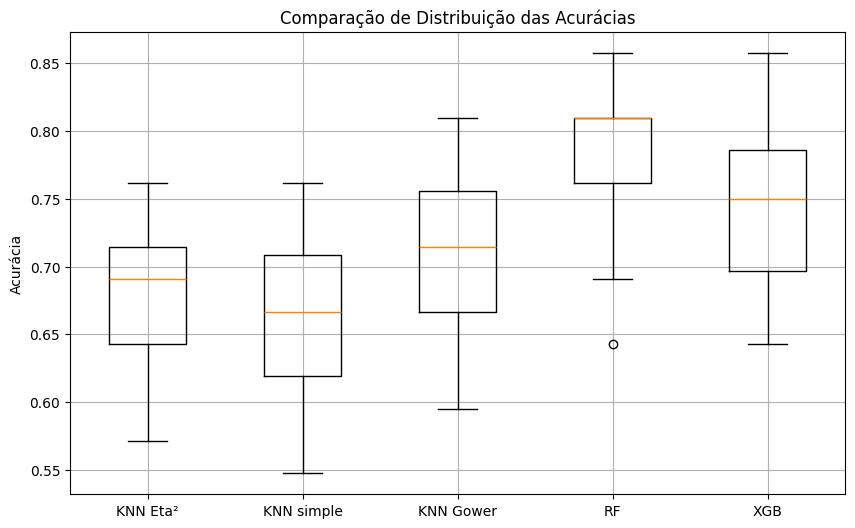

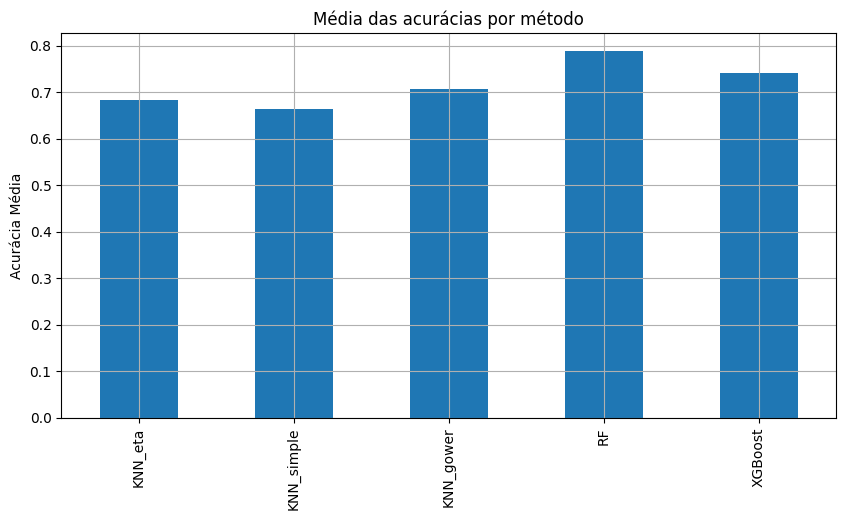

In [2]:
import pandas as pd
import numpy as np
import random
from collections import Counter
from scipy.spatial.distance import cdist

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# -------------- FUNÇÕES AUXILIARES DO KNN -----------------
# ----------------------------------------------------------

def eta_squared(x, y):
    classes = y.dropna().unique()
    grand_mean = x[y.notna()].mean()
    ss_between = sum([
        len(x[y == cl]) * ((x[y == cl].mean() - grand_mean) ** 2)
        for cl in classes
    ])
    ss_total = sum((x[y.notna()] - grand_mean) ** 2)
    return ss_between / ss_total if ss_total != 0 else 0


def gower_distance_matrix(X):
    X = X.copy()
    ranges = X.max() - X.min()
    X_norm = (X - X.min()) / ranges
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        dist_matrix[i] = np.abs(X_norm.values[i] - X_norm.values).mean(axis=1)
    return dist_matrix


def knn_impute(row_idx, df_weighted, df_target, k=5):
    row = df_weighted.iloc[row_idx].values.reshape(1, -1)
    df_known = df_weighted[df_target.notna()]
    target_known = df_target[df_target.notna()]
    
    distances = cdist(row, df_known.values, metric='euclidean').flatten()
    nearest_indices = df_known.index[np.argsort(distances)[:k]]
    nearest_labels = target_known.loc[nearest_indices]
    
    return Counter(nearest_labels).most_common(1)[0][0]


def knn_impute_simple(row_idx, df_scaled, df_target, k=5):
    row = df_scaled.iloc[row_idx].values.reshape(1, -1)
    df_known = df_scaled[df_target.notna()]
    target_known = df_target[df_target.notna()]
    
    distances = cdist(row, df_known.values, metric='euclidean').flatten()
    nearest_indices = df_known.index[np.argsort(distances)[:k]]
    nearest_labels = target_known.loc[nearest_indices]
    
    return Counter(nearest_labels).most_common(1)[0][0]


def knn_impute_gower(row_idx, gower_matrix, df_target, k=5):
    distances = gower_matrix[row_idx]
    known_mask = df_target.notna().values
    distances_known = distances[known_mask]
    indices_known = np.where(known_mask)[0]

    nearest_idxs = indices_known[np.argsort(distances_known)[:k]]
    nearest_labels = df_target.iloc[nearest_idxs]
    
    return Counter(nearest_labels).most_common(1)[0][0]


# ----------------------------------------------------------
# -------------- EXPERIMENTOS: KNN / RF / XGB --------------
# ----------------------------------------------------------

def experiment_all(seed, missing_frac=0.2, k_knn=5):

    # --- carregar dataset ---
    file_path = "data/glass.data"
    columns = ['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type_of_glass']
    df = pd.read_csv(file_path, header=None, names=columns)
    df.drop(columns=['Id'], inplace=True)
    df_original = df.copy()

    # --- inserir MCAR ---
    random.seed(seed)
    n_missing = int(missing_frac * len(df))
    missing_indices = random.sample(list(df.index), n_missing)
    df.loc[missing_indices, 'Type_of_glass'] = np.nan

    # --- colunas ---
    numerical_cols = df.columns.drop('Type_of_glass')

    # ================== KNN PESOS (ETA²) ===================
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

    # recalcula eta² usando dataset original (importante!)
    etas = {col: eta_squared(df_original[col], df_original['Type_of_glass']) for col in numerical_cols}
    etas_series = pd.Series(etas)
    df_weighted = df_scaled * etas_series

    df_imputed = df['Type_of_glass'].copy()
    for idx in df_imputed[df_imputed.isna()].index:
        df_imputed[idx] = knn_impute(idx, df_weighted, df['Type_of_glass'], k=k_knn)

    acc_weighted = accuracy_score(df_original.loc[missing_indices, 'Type_of_glass'],
                                  df_imputed.loc[missing_indices])

    # ================== KNN SIMPLES ===================
    df_scaled_simple = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)
    df_imputed_simple = df['Type_of_glass'].copy()
    for idx in df_imputed_simple[df_imputed_simple.isna()].index:
        df_imputed_simple[idx] = knn_impute_simple(idx, df_scaled_simple, df['Type_of_glass'], k=k_knn)

    acc_simple = accuracy_score(df_original.loc[missing_indices, 'Type_of_glass'],
                                df_imputed_simple.loc[missing_indices])

    # ================== KNN GOWER ===================
    gower_matrix = gower_distance_matrix(df[numerical_cols])
    df_imputed_gower = df['Type_of_glass'].copy()
    for idx in df_imputed_gower[df_imputed_gower.isna()].index:
        df_imputed_gower[idx] = knn_impute_gower(idx, gower_matrix, df['Type_of_glass'], k=k_knn)

    acc_gower = accuracy_score(df_original.loc[missing_indices, 'Type_of_glass'],
                               df_imputed_gower.loc[missing_indices])

    # ================== RANDOM FOREST ===================
    df_notnull = df[df['Type_of_glass'].notna()]
    df_null = df[df['Type_of_glass'].isna()]

    X_train = df_notnull.drop(columns=['Type_of_glass'])
    y_train = df_notnull['Type_of_glass']
    X_pred = df_null.drop(columns=['Type_of_glass'])

    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_pred)

    acc_rf = accuracy_score(df_original.loc[df_null.index, 'Type_of_glass'], y_pred)

    # ================== XGBOOST ===================
    le = LabelEncoder()
    y_train_xgb = le.fit_transform(df_notnull['Type_of_glass'].astype(int))

    xgb = XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=200
    )
    xgb.fit(X_train, y_train_xgb)

    y_pred_encoded = xgb.predict(X_pred)
    y_pred_xgb = le.inverse_transform(y_pred_encoded)

    acc_xgb = accuracy_score(df_original.loc[df_null.index, 'Type_of_glass'], y_pred_xgb)

    # retorno de todos
    return acc_weighted, acc_simple, acc_gower, acc_rf, acc_xgb


# ----------------------------------------------------------
# --------------------- RODAR TUDO -------------------------
# ----------------------------------------------------------

seeds = list(range(10, 40))
results = []

for s in seeds:
    print(f"Rodando seed {s}...")
    acc_w, acc_s, acc_g, acc_rf, acc_xgb = experiment_all(s)
    results.append({
        'seed': s,
        'KNN_eta': acc_w,
        'KNN_simple': acc_s,
        'KNN_gower': acc_g,
        'RF': acc_rf,
        'XGBoost': acc_xgb
    })

df_results = pd.DataFrame(results)
print("\nResumo geral:\n")
print(df_results.describe())

# ----------------------------------------------------------
# ------------------ GRÁFICOS FINAIS -----------------------
# ----------------------------------------------------------

plt.figure(figsize=(10,6))
plt.boxplot([df_results['KNN_eta'], df_results['KNN_simple'], df_results['KNN_gower'],
             df_results['RF'], df_results['XGBoost']],
            labels=['KNN Eta²','KNN simple','KNN Gower','RF','XGB'])
plt.title("Comparação de Distribuição das Acurácias")
plt.ylabel("Acurácia")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
df_results.drop(columns='seed').mean().plot(kind='bar')
plt.title("Média das acurácias por método")
plt.ylabel("Acurácia Média")
plt.grid(True)
plt.show()


Observa-se que os boxplots apresentam variações significativas nas acurácias entre os diferentes seeds, incluindo whiskers longos e a presença de outliers. Esse comportamento indica que o desempenho dos métodos de imputação é sensível ao padrão aleatório de valores ausentes gerado pelo mecanismo MCAR. Em outras palavras, dependendo das posições onde os valores são removidos, a estrutura dos dados pode favorecer ou prejudicar o processo de imputação, produzindo desempenhos distintos. Dessa forma, a utilização de múltiplos seeds não apenas evita conclusões enviesadas por uma configuração específica, mas também permite capturar a variabilidade intrínseca do processo, fornecendo uma avaliação mais robusta e confiável dos métodos analisados.